In [1]:
import numpy as np
import pandas as pd
from datetime import date
from nsepy import get_history
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [2]:
TRAIN_START_DATE = date(2016,4,1)
TRAIN_END_DATE = date(2021,3,31)

TEST_START_DATE = date(2021,4,1)
TEST_END_DATE = date(2021,11,9)

In [3]:
class Company:
    def __init__(self,ticker,start,end):
        self.ticker = ticker
        self.stock_data = get_history(symbol=ticker, start=start, end=end)
        self.stock_data['Date'] = self.stock_data.index
        df = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
        df['Date'] = self.stock_data['Date']
        df['Open'] = self.stock_data['Open']
        df['High'] = self.stock_data['High']
        df['Low'] = self.stock_data['Low']
        df['Close'] = self.stock_data['Close']
        self.df=df
        train_set = self.df.iloc[:, 1:2].values
        self.sc = MinMaxScaler(feature_range = (0, 1))
        self.training_set_scaled = self.sc.fit_transform(train_set) 
    def print_ticker(self):
        print(self.ticker)
        
    def get_training_set(self):  
        X_train = []
        y_train = []
        for i in range(60, len(self.stock_data)):
            X_train.append(self.training_set_scaled[i-60:i, 0])
            y_train.append(self.training_set_scaled[i, 0]) 
        X_train, y_train = np.array(X_train), np.array(y_train)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        return X_train, y_train
    def plot_stock(self):
        plt.figure(figsize=(14,5))
        plt.plot(self.stock_data['Close'])
        plt.title('Historical Stock Value (NSE: '+self.ticker+")")
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.show()
    def predict(self,regressor,X_test):
        predicted_stock_price = regressor.predict(X_test)
        predicted_stock_price = self.sc.inverse_transform(predicted_stock_price)
        return predicted_stock_price
    def get_test_set(self, testdata):
        testdata['Date'] = testdata.index
        df = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
        df['Date'] = testdata['Date']
        df['Open'] = testdata['Open']
        df['High'] = testdata['High']
        df['Low'] = testdata['Low']
        df['Close'] = testdata['Close']
        test_set = df.iloc[:, 1:2].values
        self.dataset_total = pd.concat((self.df['Open'], df['Open']), axis = 0)
        inputs = self.dataset_total[len(self.dataset_total) - len(df) - 60:].values
        inputs = inputs.reshape(-1,1)
        inputs = self.sc.transform(inputs)
        X_test = []
        for i in range(60, len(df)):
            X_test.append(inputs[i-60:i, 0])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        return X_test, test_set

In [4]:
deepakntr = Company(ticker="DEEPAKNTR", start=TRAIN_START_DATE, end=TRAIN_END_DATE)
#mastek = Company(ticker="MASTEK", start=TRAIN_START_DATE, end=TRAIN_END_DATE)
#mrf = Company(ticker="MRF", start=TRAIN_START_DATE, end=TRAIN_END_DATE)

In [5]:
X_train, y_train = deepakntr.get_training_set()

In [6]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

In [7]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [8]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
37/37 [==============================] - 12s 87ms/step - loss: 0.0133
Epoch 2/50
37/37 [==============================] - 3s 85ms/step - loss: 0.0025
Epoch 3/50
37/37 [==============================] - 3s 88ms/step - loss: 0.0015
Epoch 4/50
37/37 [==============================] - 3s 88ms/step - loss: 0.0015
Epoch 5/50
37/37 [==============================] - 3s 88ms/step - loss: 0.0013
Epoch 6/50
37/37 [==============================] - 3s 89ms/step - loss: 0.0013
Epoch 7/50
37/37 [==============================] - 3s 91ms/step - loss: 0.0017
Epoch 8/50
37/37 [==============================] - 3s 92ms/step - loss: 0.0015
Epoch 9/50
37/37 [==============================] - 3s 92ms/step - loss: 0.0016
Epoch 10/50
37/37 [==============================] - 3s 93ms/step - loss: 0.0015
Epoch 11/50
37/37 [==============================] - 3s 94ms/step - loss: 0.0017
Epoch 12/50
37/37 [==============================] - 3s 94ms/step - loss: 0.0016
Epoch 13/50
37/37 [=================

In [21]:
deepakntr_test = Company(ticker="DEEPAKNTR", start=TEST_START_DATE, end=TEST_END_DATE)
X_test, y_test = deepakntr.get_test_set(deepakntr_test.stock_data)

In [22]:
y_pred = deepakntr.predict(regressor,X_test)

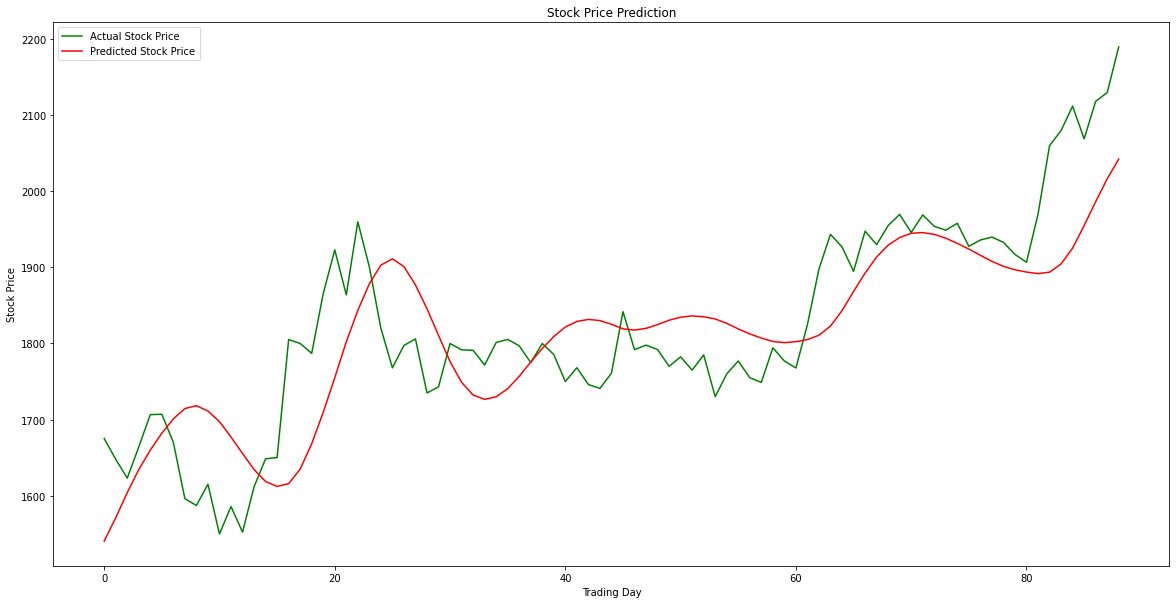

In [23]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:len(y_test)-60], color = 'green', label = 'Actual Stock Price')
plt.plot(y_pred, color = 'red', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('Stock Price')
plt.legend()
plt.show()